# Land Use/Land Cover

In [1]:
import pygeohydro as gh
from pynhd import NLDI

Land cover, imperviousness, and canopy data can be retrieved from the [NLCD](https://www.mrlc.gov/data) database. First, we use [PyNHD](https://github.com/cheginit/pynhd) to get the contributing watershed geometry of a NWIS station with the ID of `USGS-01031500`:

In [2]:
geometry = NLDI().get_basins("01315500").geometry[0]

We can now use the ``nlcd`` function to get the data. This function has one positional argument for passing the geometry which could be a Polygon or a boundig box. If CRS of the geometry is not EPSG:4326, it should be passed via ``geo_crs`` argument. The second argument is the target resolution of the data in meters. The NLCD database is multi-resolution and based on the target resolution, the source data are resampled on the server side.

You should be mindful of the resolution since higher resolutions require more memory so if your requests requires more memory than the available memory on your system the code is likely to crash. You can either increase the resolution or divide your region of interest into smaller regions.

Moreover, the [MRLC](https://www.mrlc.gov/geoserver/web/) GeoServer has a limit of about 8 million pixels per request but PyGeoHydro takes care of the domain decomposition under-the-hood and divides the request to smaller requests then merges them. So the only bottleneck for requests is the amount of available memory on your system.

The ``nlcd`` function can request for three layers from the MRLC web service; imperviousness, land use/land cover, and tree canopy. Since NLCD is released every couple of years, you can specify the target year via the ``years`` argument. Layers that are not included in this argument are ignored. By default `years` is `{'impervious': [2019], 'cover': [2019], 'canopy': [2019], "descriptor": [2019]}`.

Furthermore, we can specify the region of interest as well via `region` argument. Valid values are `L48` (for CONUS), `HI` (for Hawaii), `AK` (for Alaska), and `PR` (for Puerto Rico). By default, region is set to `L48`.

Let's get the cover and impervious descriptor data at a 100 m resolution.

In [3]:
desc = gh.nlcd(geometry, 100, years={"descriptor": 2019})

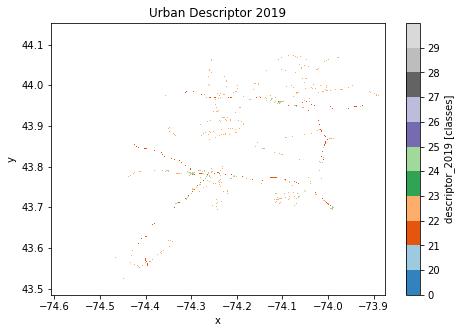

In [4]:
cmap, norm, levels = gh.plot.descriptor_legends(cmap_name="tab20c")
ax = desc.descriptor_2019.plot(size=5, cmap=cmap, levels=levels, cbar_kwargs={"ticks": levels[:-1]})
ax.axes.set_title("Urban Descriptor 2019")
ax.figure.savefig("_static/descriptor.png", bbox_inches="tight", facecolor="w")

In [5]:
lulc = gh.nlcd(geometry, 100, years={"cover": [2016, 2019]})

Additionally, `PyGeoHydro` provides a function for getting the official legends of the cover data. Let's plot the data using this legends.

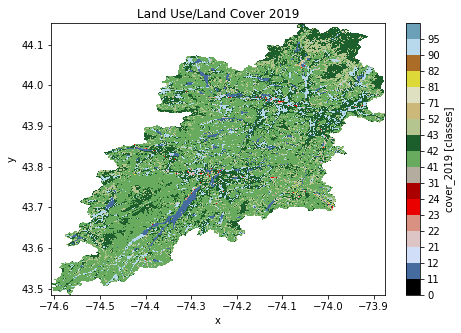

In [6]:
cmap, norm, levels = gh.plot.cover_legends()
ax = lulc.cover_2019.plot(size=5, cmap=cmap, levels=levels, cbar_kwargs={"ticks": levels[:-1]})
ax.axes.set_title("Land Use/Land Cover 2019")
ax.figure.savefig("_static/lulc.png", bbox_inches="tight", facecolor="w")

Moreover, we can get the statistics of the cover data for each class or category as well:

In [7]:
stats = gh.cover_statistics(lulc.cover_2019)
stats

{'classes': {'Open Water': 3.487316421895861,
  'Developed, Open Space': 0.8836023789294817,
  'Developed, Low Intensity': 0.20293724966622162,
  'Developed, Medium Intensity': 0.11214953271028037,
  'Developed, High Intensity': 0.01602136181575434,
  'Barren Land (Rock/Sand/Clay)': 0.03641218594489622,
  'Deciduous Forest': 51.96067483917951,
  'Evergreen Forest': 23.21446777521544,
  'Mixed Forest': 11.03143585386576,
  'Shrub-Forest': 0.8569001092365578,
  'Herbaceous-Forest': 0.1427357689039932,
  'Shrub/Scrub': 0.06991139701420075,
  'Grassland/Herbaceous': 0.17574948416069913,
  'Pasture/Hay': 0.06117247238742565,
  'Cultivated Crops': 0.004369462313387547,
  'Woody Wetlands': 7.24214103653356,
  'Emergent Herbaceous Wetlands': 0.5020026702269693},
 'categories': {'Background': 0.0,
  'Unclassified': 0.0,
  'Water': 3.487316421895861,
  'Developed': 1.214710523121738,
  'Barren': 0.03641218594489622,
  'Forest': 87.20621434640127,
  'Shrubland': 0.06991139701420075,
  'Herbaceous